<a href="https://colab.research.google.com/github/workwithjahan/MISA_tutorial_Jose/blob/main/eshrat_ehealth_Tutorial_by_c_t_m_Xplique_Attribution_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://deel-ai.github.io/xplique/

In [1]:
!pip install -U -q xplique

     |████████████████████████████████| 131 kB 5.2 MB/s 


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
from time import time

import xplique
from xplique.attributions import GradCAM, GradCAMPP, Saliency, DeconvNet, GradientInput, GuidedBackprop, SmoothGrad, SquareGrad, VarGrad, Lime, KernelShap
from xplique.plots import plot_attributions

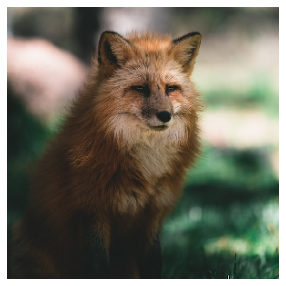

In [3]:
# load, prepare and show the sample
!wget -q 'https://unsplash.com/photos/XOxsVJmCyxk/download?force=true&w=640' -O 'fox.jpg'

x = np.expand_dims(tf.keras.preprocessing.image.load_img("fox.jpg", target_size=(299, 299)), 0)
x = np.array(x, dtype=np.float32) / 255.0

y = np.expand_dims(tf.keras.utils.to_categorical(277, 1000), 0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

Now we will load an image and a well-known model [Inception V3](https://keras.io/api/applications/inceptionv3/).

In [4]:
# load the model
model = tf.keras.applications.InceptionV3()

96112376/96112376 [==============================] - 0s 0us/step


## <a name="simple">Saliency Maps</a>

The saliency method is the first gradient-based method, thus the simpliest. The importance is given by the absolute value of the gradient (for a given class).

$$ \phi_c(x) = |\frac{\delta S_c(x)}{\delta x}| $$

### <a name="simple">Method simple utilisation</a>

This a minimal example on how to apply the Saliency method.

Saliency


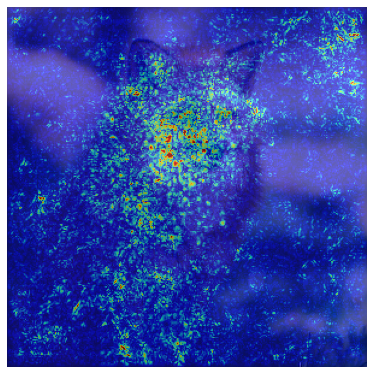

In [5]:
# define arbitrary parameters (common for all methods)
parameters = {
    "model": model,
    "output_layer": None,
    "batch_size": 16,
}

# instanciate one explainer for each method
explainers = {
    "Saliency": Saliency(**parameters)
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='jet', cols=1, alpha=0.6)

### <a name="simple">Parameters tuning tips</a>

- The `output_layer` represent the index or name of the layer from which begin the back-propagation. It should be left to -1, i.e the last layer of the model or the class activation layer. We suggest not to change it as the resulting attributions would not be easily interpretable and may be misleading.
- The `batch_size` represent the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training. The parameter should be a positive integer.

## <a name="simple">GradCAM</a>



<a href="https://arxiv.org/abs/1610.02391">Ramprasaath et al.</a> described Grad-CAM as "*Grad-CAM uses the gradient information flowing into the
last convolutional layer of the CNN to assign importance
values to each neuron for a particular decision of interest.*"

The method is really close to CAM, they also assign attribution to the last convolutionnal layer and upsample them to the input size. They also use the GAP function. Nevertheless, there desing allow the use of the method each convolutionnal layer and the last layer do not need to necessarly be a dense layer.

The difference with the CAM method is there use of the gradient computed via back-propagation $g_{ij}^{kc} = \frac{\delta S_c}{\delta A_{ij}^k}$. Where $S_c$ the unormalized score (layer before softmax) for class $c$ and $A_{ij}^k$ the activation of the studied convolutionnal layer output at channel $k$ and coodinates $(i,j)$.

They define the coefficient $\alpha_k^c$ by taking the GAP of this gradient. Z represent the number of elements in a channel of the studied convolutionnal layer.

$$\alpha_c^k = \frac{1}{Z} \sum_i \sum_j g_{ij}^{kc}$$

Now, on the computation of the convolutionnal layer attributions can be defined through the following formula, where $GradCAM_c$ are the convolutionnal attributions for class $c$. The GAP are weighted by $A^k$ the activations of channel $k$. $ReLU$ is the rectified linear unit function.

$$ GradCAM_c = ReLU(\sum_k \alpha_c^k A^k)$$

Therefore, explanation function $\phi_c$ of a class $c$, can be defined by:

$$\phi_c(x) = upsample_{size(x)}(GradCAM_c) $$

### <a name="simple">Method simple utilisation</a>

This a minimal example on how to apply the GradCAM method. 

GradCAM


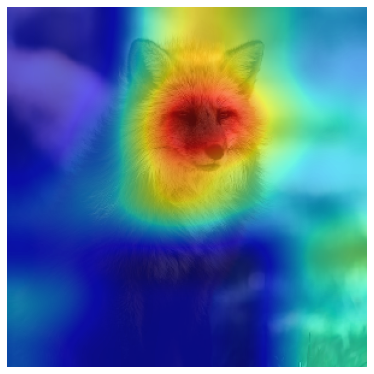

In [7]:
# define arbitrary parameters (common for all methods)
parameters = {
    "model": model,
    "output_layer": -1,
    "batch_size": 16,
    "conv_layer": None,
}

# instanciate one explainer for each method
explainers = {
    "GradCAM": GradCAM(**parameters),
  
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='jet', cols=1, alpha=0.6)

### <a name="simple">Parameters tuning tips</a>

- The `output_layer` represents the index or name of the layer from which begin the back-propagation. It should be left to None, i.e the last layer of the model or the class activation layer.
- The `batch_size` represents the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training.
- The `conv_layer` parameter represents the index or the name of the convolutionnal layer the algorithm is applied on. It should be left to `None` to select the last convolutionnal layer in most cases.

## <a name="simple">Lime </a>

The Lime method try to find a function $g$ that approximate our model $f$ in the vicinity of $x$ the studied input sample. The goal is to find a function $g$ with a behavior the closest possible to $f$ but remaining simple and thus interpretable. The coefficients of the learnt $g$ function are given as an explanation.

Before explaining how $g$ is obtained, it is important to distinguish between features and interpretable data representations. For human to understand explanations, those need to be in an intepretable space. In Lime, the interpretable space can be seen as a space where features of an input $x$ were grouped together. (For example group letters as words for text or pixels as super-pixels for images). All elements $e$ have in interpreatable representation $e'$ in the intepretable space, $g$ input space is the interpretable space.

To approximate $f$ with $g$, perturbed samples $z$ are generated aroud the studied input $x$, a random number of features is perturbed to a given reference value. The model $f$ allow us to make label for those samples $z$. The method also define a similarity function $\pi_x$ that estimates the similarity between the studied sample $x$ and the generated samples $z$. Then the function $g$ is trained on those samples/labels pairs (in the intepretable space) using the similarity function to weight the impact of each sample.

The authors introduce two elements, the first, $\mathcal{L}(f,g,\pi_x)$ a measure of how unfaithful $g$ is in approximating $f$ in the locality defined by $\pi_x$. The second, $\Omega(g)$ a measure of the complexity of $g$ (as opposed to interpretability), (an example would be the depth of a decision tree). Finally, the explainer is defined as:
$$\xi(x) = \underset{g\in G}{\mathrm{argmin}} \space\space \mathcal{L}(f,g,\pi_x) + \Omega(g)$$

In Xplique as in the original paper, we take $g$ from the ensemble of linear models, such that $g(z') = w_{g} . z'$. Then the explanations are the coefficients $w_{\xi(x)}$.

### <a name="simple">Method simple utilisation</a>

This a minimal example on how to apply the Saliency method.
We could say that there are simple and complex parameters in the method. Thus beginning with simple parameters should be natural. As such, the simple parameters are:

- `nb_samples`
- `ref_value`
- `distance_mode` 
- `kernel_width`
- `prob`

Other parameters are functions, thus their definition is more complex and use not default ones, you need deep understanding of the method.

In [8]:
from sklearn import linear_model

In [ ]:
# define arbitrary parameters (common for all methods)

lime_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # will use the default function
    "nb_samples": 4000,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
    "interpretable_model": linear_model.Ridge(alpha=2),
    "similarity_kernel": None,  # will use the default function
    "pertub_func": None,  # will use the default function
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

# instanciate one explainer for each method
explainers = {
    "Lime": Lime(**lime_parameters),
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='RdBu', cols=1, alpha=0.6)
    plt.colorbar()

### <a name="simple">Parameters tuning tips</a>

**Parameters:**

- The `batch_size` represents the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training.

- The `map_to_interpret_space` is a function grouping coherent pixels together (image segmentation). The functions doing segmentation have several parameters, tuning them may take some time. Thus, we suggest to modify it only if the super-pixels do not make sense on your image. 

- The `nb_samples` represents the number of samples (perturbed sample) used by the estimator for each sample (image, timeseries...). The right setting is the smallest value after which the explanation are stable. This means that more sample will not make the explanation more precise. `nb_samples` default value is (150 for Lime, 800 for KernelShap), the bigger the input size, the bigger should be the number of samples.

- The `ref_value` defines the reference value which replaces each feature when the corresponding interpretable feature is set to 0. It should represent non-information. 0 or the mean of your values are often good values. If you have several channels, the different values should represent the same thing (i.e all zeros or all means along the channel).

- The `interpretable_model` parameter represents an interpretable model object, this model is train on pertubed samples to approximate the original model locally. It is hard to predict the impact of such parameter, thus if you not have a deep understanding and a goal in mind, we do not suggest to modify this parameter. 

- The `similarity_kernel` is a function for measuring the similarity between perturbed samples and the original input. To change this parameter you need to write a custom function, which ask for a good understanding of the method. Therefore, we suggest to modify this function via the `distance_mode` and `kernel_width` parameters.

- The `pertub_function` is a function which generate perturbed interpretable samples in the interpretation space. To change this parameter, you also need a custom function. Therefore to modify the `pertub_function` we suggest to do it via the `prob` parameter. 

- The `distance_mode` is the dist parameter used by the default `similarity_kernel` function. It is either "euclidean" or "cosine", both are pertinent and should be tried. ("euclidean" is the default). 

- The `kernel_width` is the width of the default `similarity_kernel` function. This parameter depend on the input size, the default value is 45, it is tuned for 224x224 images. You may use 1 for tabular data or small time series. While a bigger value should be taken for bigger images. It is important to make it evolving depending on your inputs size otherwise you will get all similarity close to 0 leading to poor performance or errors.

- The `prob` parameter is used by the default `perturb_function`. It determines the probability of a feature (super-pixel) to be perturbed. The value should stay between 0.1 and 0.9. (The default value is 0.5).

### <a name="influence">Parameters influence</a>


#### **nb_samples**


- A too small number of sample will not provide a precise enough estimator, thus leading to noisy explanations.
- A too large number of sample can only have a good impact on the explanation, however it will impact the computation time linearly.



nb_samples=40, nb_samples=400, nb_samples=4000

Lime1
Lime2
Lime3


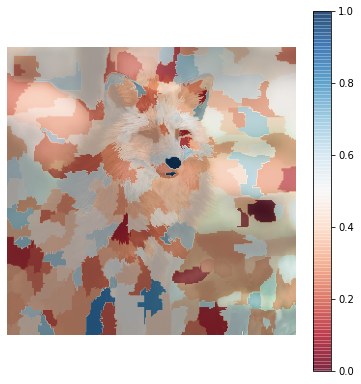

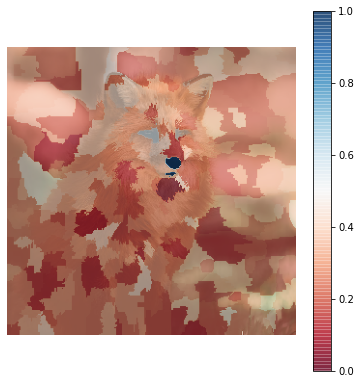

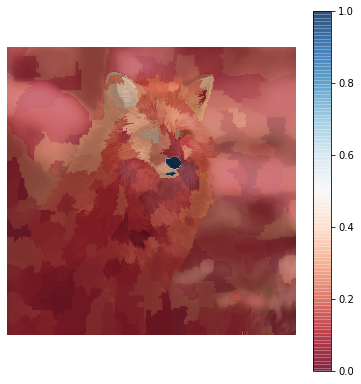

In [ ]:
# define parameters 

lime_parameters1 = {
    "model": model,
    "batch_size": 16,
    "nb_samples": 40,
    "ref_value": None,  # default value  
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value 
    "prob": 0.5,  # default value
}

lime_parameters2 = {
    "model": model,
    "batch_size": 16,
    "nb_samples": 400,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

lime_parameters3 = {
    "model": model,
    "batch_size": 16,
    "nb_samples": 4000,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

# instanciate one explainer for each method
explainers = {
    "Lime1": Lime(**lime_parameters1),
    "Lime2": Lime(**lime_parameters2),
    "Lime3": Lime(**lime_parameters3),
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='RdBu', cols=1, alpha=0.6)
    plt.colorbar()

#### **distance_mode**

The `distance_mode` is the dist parameter used by the default `similarity_kernel` function. 

Only support "euclidean" or "cosine" as values.

distance_mode="euclidean", distance_mode="cosine"

Lime1


Lime2


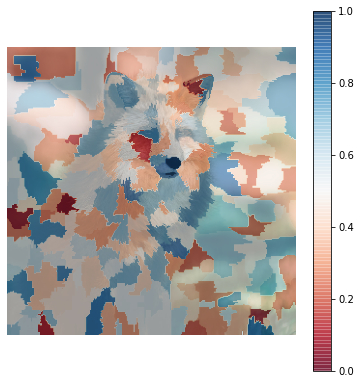

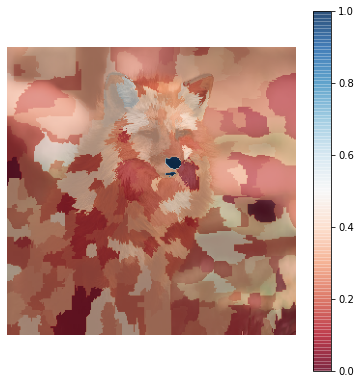

In [ ]:
# define parameters 

lime1_parameters = {
    "model": model,
    "batch_size": 16,
    "nb_samples": 400,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

lime2_parameters = {
    "model": model,
    "batch_size": 16,
    "nb_samples": 400,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
    "distance_mode": "cosine",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

# instanciate one explainer for each method
explainers = {
    "Lime1": Lime(**lime_parameters1),
    "Lime2": Lime(**lime_parameters2)
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='RdBu', cols=1, alpha=0.6)
    plt.colorbar()